## Clutch Hitting
Import the data and Define some functions

In [1]:
#Import libraries and s
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Column reference:
# https://baseballsavant.mlb.com/csv-docs

#Import Data
#Read in the Statcast Data - note this is around 4GB of data!
stat_15 = pd.read_csv('../data/external/statcast_15.zip', parse_dates=['game_date'])
stat_16 = pd.read_csv('../data/external/statcast_16.zip', parse_dates=['game_date'])
stat_17 = pd.read_csv('../data/external/statcast_17.zip', parse_dates=['game_date'])
stat_18 = pd.read_csv('../data/external/statcast_18.zip', parse_dates=['game_date'])
stat_19 = pd.read_csv('../data/external/statcast_19.zip', parse_dates=['game_date'])
stat_20 = pd.read_csv('../data/external/statcast_20.zip', parse_dates=['game_date'])

#Combine the data into a single dataframe
stat_years_combined_list = [
    stat_15, 
    stat_16, 
    stat_17, 
    stat_18, 
    stat_19,
    stat_20
]

stat_years_combined_df = pd.concat(
    stat_years_combined_list, 
    ignore_index=True
)

#Split out years
stat_years_combined_df['year'] = stat_years_combined_df[
    'game_date'
].apply(lambda x: x.strftime('%Y'))

#Subset for what I need
stat_comb = stat_years_combined_df[
    ['index', 
     'game_date',
     'year',
     'batter',
     'pitcher',
     'player_name',
     'events',
     'game_type',
     'home_team',
     'away_team',
     'home_score',
     'away_score',
     'bat_score',
     'fld_score',
     'on_1b',
     'on_2b',
     'on_3b',
     'post_home_score',
     'post_away_score',
     'inning',
     'hit_distance_sc',
     'launch_speed',
     'launch_angle',
     'launch_speed_angle',
     'effective_speed',
     'release_speed',
     'release_spin_rate',
     'estimated_ba_using_speedangle',
     'estimated_woba_using_speedangle',
     'pitch_name'
    ]
]

#add_player names
names = pd.read_csv('../data/external/name_master.csv', encoding = "utf-8")
#names.columns

print('Data imported successfully.\nFormatting and cleaning data...')

#Get we want regular season games:
stat_comb = stat_comb[stat_comb.game_type == 'R']

#Convert NaN to zero for the on-base colums=ns
values = {'on_1b':0,'on_2b':0,'on_3b':0}
stat_comb.fillna(value=values, inplace=True)

#Replace the playerID with an integer for the 1,2 and 3b colums:
stat_comb['on_1b'] = stat_comb['on_1b'].where(stat_comb['on_1b'] == 0, 1)
stat_comb['on_2b'] = stat_comb['on_2b'].where(stat_comb['on_2b'] == 0, 1)
stat_comb['on_3b'] = stat_comb['on_3b'].where(stat_comb['on_3b'] == 0, 1)

#stat_comb[['on_1b','on_2b','on_3b']].head(20)
print('Done!')

Data imported successfully.
Formatting and cleaning data...
Done!


Define workbook functions here

In [2]:
#Functions
from pybaseball import playerid_lookup

def is_clutch(df):
    '''A function which returns whether the event was in a clutch situation. 
    Takes a dataframe as input, returns boolean.
    Uses the statcasat dataset and requires the columns:
        'bat_score' -> int
        'fld_score' -> int
        'inning' -> int
        'on_1b' -> 1 or 0
        'on_2b' -> 1 or 0
        'on_3b' -> 1 or 0
    Note the is_clutch is defined as seen from the perspective of the batter. 
    '''
    if df['inning'] >= 7: #are we in the 7th inning or later, or 6th if we are in 2020?
        score_diff = df['bat_score'] - df['fld_score']
        if ((score_diff == 1) | (score_diff == 0)): #Are they tying, or leading by one point?
            return True
        elif score_diff < 0: #Are they trailing?
            #is the tying run 'on hand'?
            base_status = df['on_1b'] + df['on_2b'] + df['on_3b']#possible runs from bases. 
            if base_status + 2 + score_diff >= 0: 
                return True
            else:
                return False
        else:
            return False
    else:
        return False

## Analysis

Let's create two datasets, one during the clutch situations and one not during the clutch situations. 

In [3]:
#Write an extra column to determine whether the row event 
#was a clutch event
stat_comb['clutch'] = stat_comb.apply(is_clutch, axis=1)
stat_comb['clutch'].value_counts()

#Create the data frame with and without clutch events
clutch_df = stat_comb[stat_comb['clutch'] == True]
not_clutch_df = stat_comb[stat_comb['clutch'] == False]

#Sanity checks if required:
#clutch_df[['inning','year']].value_counts()
#clutch_df.columns

Launch Speed Angle

In [4]:
## Data Cleaning and Checks
#drop empty values:
clutch_df = clutch_df.dropna(how='any', subset=['launch_speed_angle'])
not_clutch_df = not_clutch_df.dropna(how='any', subset=['launch_speed_angle'])

#sanity_check:
#clutch_df.launch_speed_angle.agg(['unique','count'])
#not_clutch_df.launch_speed_angle.agg(['unique','count'])

#Group by batter
clutch_by_batter = clutch_df.groupby("batter")
nclutch_by_batter = not_clutch_df.groupby("batter")

In [136]:
#Pick a player:
#Garcia: 541645.0 - tends to perform better in the clutch
#Seager: 608369.0 - tends to perform worse in the clutch.
player_id = 541645.0
c_player_df = clutch_df[(clutch_df["batter"]==player_id) & (clutch_df["launch_speed_angle"]==6)]
c_player_df2 = clutch_df[(clutch_df["batter"]==player_id) & (clutch_df["launch_speed_angle"]!=6)]
nc_player_df =  not_clutch_df[(not_clutch_df["batter"]==player_id) & (not_clutch_df["launch_speed_angle"]==6)]

In [139]:
## Basically I need to make 3 ordered lists of the dates, whether it was a barrel or not, and the colour of the line I want to draw.
from datetime import datetime
#Get all the dates
ts_c_data = c_player_df['game_date'].values #Barrels in clutch situations
ts_c2_data = c_player_df2['game_date'].values #Nonbarrels in clutch situations
ts_nc_data = nc_player_df['game_date'].values #Barrels in nonclutch situatios 

#Turn this all into one list and format dates correctly for matplotlib
date_ar1 = np.concatenate((ts_nc_data, ts_c_data), axis=0)
date_arr = np.concatenate((date_ar1, ts_c2_data), axis=0)
dates = [date.astype("M8[ms]").tolist() for date in date_arr]
#Create levels for plot -1 for non-clutch barrel, 1 for clutch barrel

#Just add different lengths for the lines that I want to plot, in the same order as above. 
ts_c_bar = np.full((len(ts_c_data)), 0.6)
ts_c2_bar = np.full((len(ts_c2_data)), 0.5)
ts_nc_bar = np.full((len(ts_nc_data)), -0.5)

level = np.concatenate((ts_nc_bar, ts_c_bar), axis=0)
levels = np.concatenate((level, ts_c2_bar), axis=0)

#Now specify the colours and turn it into one list. 
ts_c = np.full((len(ts_c_data)), 'g')
ts_c2 = np.full((len(ts_c2_data)), 'r')
ts_nc = np.full((len(ts_nc_data)), 'g')

clevel = np.concatenate((ts_nc, ts_c), axis=0)
clevels = np.concatenate((clevel, ts_c2), axis=0)

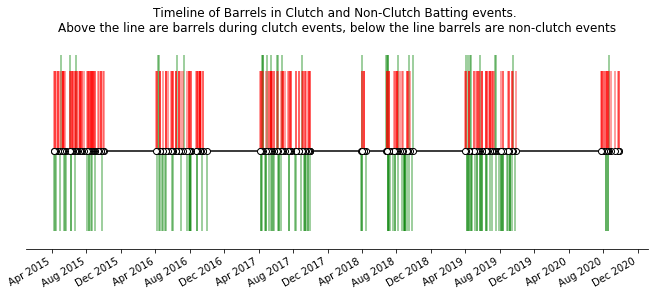

In [140]:
#plot that shit

import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(9, 4), constrained_layout=True)
ax.set(title="Timeline of Barrels in Clutch and Non-Clutch Batting events. \
\nAbove the line are barrels during clutch events, below the line barrels are non-clutch events")

ax.vlines(dates, 0, levels, color=clevels, alpha=0.5)  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# format xaxis with 4 month intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.margins(y=0.1)
plt.show()